In [1]:
import anndata
import numpy as np
import pandas as pd 
import seaborn as sb
import matplotlib.pyplot as plt
import pickle
import os,sys,inspect
import scanpy as sc

# G2G source imports 
import Main
import MyFunctions 
import TimeSeriesPreprocessor
import PathwayAnalyserV2
import VisualUtils
import ClusterUtils
import VisualUtils

import warnings
warnings.filterwarnings("ignore")
import platform
print(platform.python_version())

(CVXPY) Sep 23 09:16:03 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Sep 23 09:16:03 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
3.9.16


In [2]:
# Comparing SPT alignments to CD8 alignments
input_dir ='../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/FinalResults/'
with open(input_dir+'aligner_TF_CD8lineage.pkl', 'rb') as f:
    aligner_cd8 = pickle.load(f)
with open(input_dir+'aligner_TF_SPTDNonwards.pkl', 'rb') as f:
    aligner_spt = pickle.load(f)

In [3]:
# Below is the ranked list of genes based on alignment percentage
aligner = aligner_cd8
topDEgenes,rankedDEgenes = PathwayAnalyserV2.topkDE(aligner, DIFF_THRESHOLD=0.5)
x = PathwayAnalyserV2.get_ranked_genelist(aligner)
x = pd.DataFrame(x)

# We compute the Log2 fold change of their mean expression
l2fc = []
for gene in x.index:
    l2fc.append(np.log2(np.mean(list(aligner.ref_mat.loc[:,gene])  )/np.mean(list(aligner.query_mat.loc[:,gene])) )) 
x[2] = l2fc
x.columns = ['sim','l2fc']
x['abs_l2fc'] = np.abs(x['l2fc']) 
x = x.sort_values(['sim','abs_l2fc'],ascending=[True, False])
x_cd8 = x 

# Below is the ranked list of genes based on alignment percentage
aligner = aligner_spt
topDEgenes,rankedDEgenes = PathwayAnalyserV2.topkDE(aligner, DIFF_THRESHOLD=0.5)
x = PathwayAnalyserV2.get_ranked_genelist(aligner)
x = pd.DataFrame(x)
# We compute the Log2 fold change of their mean expression
l2fc = []
for gene in x.index:
    l2fc.append(np.log2(np.mean(list(aligner.ref_mat.loc[:,gene])  )/np.mean(list(aligner.query_mat.loc[:,gene])) )) 
x[2] = l2fc
x.columns = ['sim','l2fc']
x['abs_l2fc'] = np.abs(x['l2fc']) 
x = x.sort_values(['sim','abs_l2fc'],ascending=[True, False])
x_spt = x 

x_spt['rank']= np.asarray(range(0,len(x_spt)))
x_cd8['rank']= np.asarray(range(0,len(x_cd8)))

95  # of DE genes to check
132  # of DE genes to check


In [4]:
np.setdiff1d(x_cd8.index, x_spt.index)

array(['ARNT2', 'PRDM12', 'ZBTB32', 'ZBTB7C'], dtype=object)

In [5]:
np.setdiff1d(x_spt.index,x_cd8.index)

array(['IRF6', 'LBX2', 'POU5F1B', 'SOX10', 'ZNF541'], dtype=object)

In [6]:
l1 = list(x_cd8.index) 
l2 = list(x_spt.index)
common = np.intersect1d(l1,l2)
temp = pd.DataFrame([x_cd8.loc[common]['rank'] - x_spt.loc[common]['rank'],  
                     x_cd8.loc[common]['sim'] - x_spt.loc[common]['sim']  ,  
                     x_cd8.loc[common]['abs_l2fc'], x_spt.loc[common]['abs_l2fc']  ]   ).transpose()
temp
temp.columns = ['rank_diff','sim_diff', 'abs_l2fc_cd8', 'abs_l2fc_spt']
temp = temp.sort_values(['sim_diff'], ascending=[False])
temp[temp.rank_diff==0]

rank_diff  sim_diff  abs_l2fc_cd8  abs_l2fc_spt
Gene                                                  
USF2         0.0    0.0000      0.035035      0.082951
SNAI1        0.0    0.0000      8.883991      8.899989
IKZF3        0.0   -0.0553      1.822377      1.692261
NKRF         0.0   -0.1060      2.499642      2.543194

In [7]:
# let's check sim % based on the last 6 alignment states spt=t1
last_stage_sims_spt = [] 
last_stage_sims_cd8 = []
# let's check l2fc of last stage between ref and ato for each spt and cd8 lineage
last_stage_l2fc_spt = [] # based on interpolated mean
last_stage_l2fc_cd8 = [] # based on interpolated mean
last_stage_l2fc_t1_cd8 = [] # based on interpolated mean

for g in temp.index:
    a = aligner_spt.results_map[g]
    t = a.alignment_str[::-1][0:6]
    if(a.S.mean_trend[13]<=0): # because interpolated distribution could have a negative mean due to the fact that sampled datapoints from the interpolated guassian distribution could contain negative values
        mean_S_lastbin = 0.01
    else:
         mean_S_lastbin  = a.S.mean_trend[13]
         
    if(a.T.mean_trend[13]<=0):
        mean_T_lastbin  = 0.01
    else:
        mean_T_lastbin  = a.T.mean_trend[13]
    last_stage_l2fc_spt.append( np.log2(mean_S_lastbin/mean_T_lastbin) )
    last_stage_sims_spt.append((t.count('M') + t.count('W') + t.count('V'))/6) 
    
for g in temp.index:
    a = aligner_cd8.results_map[g]
    t = a.alignment_str[::-1][0:6]
    if(a.S.mean_trend[13]<=0):
        mean_S_lastbin = 0.01
    else:
         mean_S_lastbin  = a.S.mean_trend[13]
         
    if(a.T.mean_trend[13]<=0):
        mean_T_lastbin  = 0.01
    else:
        mean_T_lastbin  = a.T.mean_trend[13]
    last_stage_l2fc_cd8.append( np.log2(mean_S_lastbin/mean_T_lastbin) )
    last_stage_sims_cd8.append((t.count('M') + t.count('W') + t.count('V'))/6) 
    
# let's check l2fc of last stage between spt ref and cd8 ref
for g in temp.index:
    a_spt = aligner_spt.results_map[g]
    a_cd8 = aligner_cd8.results_map[g]
    if(a_spt.S.mean_trend[13]<=0):
        mean_spt_lastbin= 0.01
    else:
        mean_spt_lastbin = a_spt.S.mean_trend[13]
         
    if(a_cd8.S.mean_trend[13]<=0):
        mean_cd8_lastbin = 0.01
    else:
        mean_cd8_lastbin = a_cd8.S.mean_trend[13]
   # print(temp1,temp2)
    last_stage_l2fc_t1_cd8.append( np.log2(mean_spt_lastbin/mean_cd8_lastbin) )
    
temp['last_stage_sim_spt'] = last_stage_sims_spt
temp['last_stage_sim_cd8'] = last_stage_sims_cd8
temp['last_stage_l2fc_spt'] = last_stage_l2fc_spt
temp['last_stage_l2fc_cd8'] = last_stage_l2fc_cd8
temp['last_stage_sim_diff'] = np.asarray(last_stage_sims_spt) - np.asarray(last_stage_sims_cd8)
temp['last_stage_l2fc_diff'] = np.asarray(last_stage_l2fc_spt) - np.asarray(last_stage_l2fc_cd8)
temp['last_stage_l2fc_t1_cd8'] = last_stage_l2fc_t1_cd8 

# we are interested in high last bin alignment similarity diff between spt-ato and cd8-ato; and high l2fc between spt ref and cd8 ref
condition = np.logical_and(np.abs(temp['last_stage_sim_diff']) >= 0.5,np.abs(temp['last_stage_l2fc_t1_cd8'])>=0.5 )

t = temp[condition]
c=0
# filtering out genes which are less confident with low levels of gene expression
check_genes = []
for g in t.index: #mean max
    if ( np.mean(aligner_spt.results_map[g].S.mean_trend[11:15]) < 0.5 and np.mean(aligner_cd8.results_map[g].S.mean_trend[11:15] < 0.5)):
        c+=1
    else:
        check_genes.append(g)
t= t.loc[check_genes].sort_values('last_stage_sim_diff')

t.sort_values('last_stage_sim_diff', ascending=False)

rank_diff  sim_diff  abs_l2fc_cd8  abs_l2fc_spt  last_stage_sim_spt  \
Gene                                                                          
GATA3      -339.0   -0.1734      0.239699      0.148141            0.666667   
ARID5B     -692.0   -0.3111      0.940331      0.770878            0.666667   
FOXP1      -736.0   -0.3111      0.541296      0.353138            0.666667   
STAT3      -150.0    0.0000      0.171048      0.147814            0.833333   
SOX4       -148.0   -0.2829      0.906394      0.929832            0.500000   
ZNF428      582.0    0.3111      0.136708      0.130314            0.166667   
IKZF1       648.0    0.3930      0.425725      0.489677            0.000000   

        last_stage_sim_cd8  last_stage_l2fc_spt  last_stage_l2fc_cd8  \
Gene                                                                   
GATA3             0.000000             0.264964            -0.307497   
ARID5B            0.000000             0.120774            -1.393071   
FOXP1             0.000000             0.480979             1.714818   
STAT3             0.333333            -0.149056             0.479770   
SOX4              0.000000             0.151972             1.726100   
ZNF428            0.666667            -0.865222            -0.255768   
IKZF1             1.000000            -0.807886            -0.040297   

        last_stage_sim_diff  last_stage_l2fc_diff  last_stage_l2fc_t1_cd8  
Gene                                                                       
GATA3              0.666667              0.572462                0.572441  
ARID5B             0.666667              1.513845                1.513817  
FOXP1              0.666667             -1.233839               -1.233849  
STAT3              0.500000             -0.628827               -0.628866  
SOX4               0.500000             -1.574128               -1.574140  
ZNF428            -0.500000             -0.609454               -0.609485  
IKZF1             -1.000000             -0.767589               -0.767616

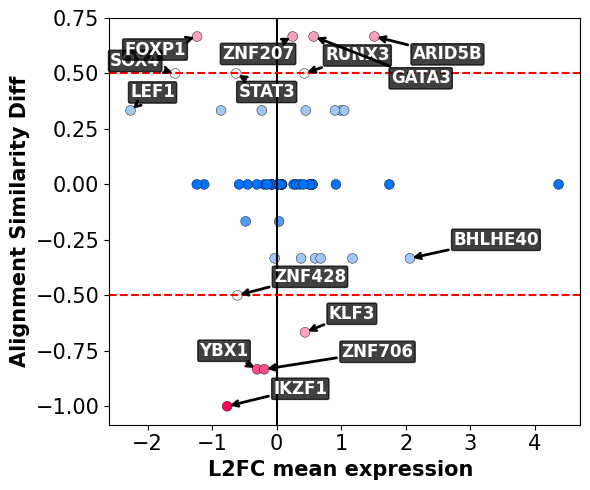

In [9]:


# PLOT volcan like ---- don't filter l2fc but below 
from adjustText import adjust_text

t = temp
c=0
check_genes = []
for g in t.index:
    if ( np.mean(aligner_spt.results_map[g].S.mean_trend[11:15]) < 0.5 and np.mean(aligner_cd8.results_map[g].S.mean_trend[11:15] < 0.5)):
        c+=1
    else:
        check_genes.append(g)
t= t.loc[check_genes].sort_values('last_stage_sim_diff')

most_DE_genes = t.index
plt.subplots(1,1,figsize=(6,5))
x = t
ax=sb.scatterplot(x=x['last_stage_l2fc_t1_cd8'],y=x['last_stage_sim_diff'],s=50, legend=False, hue =np.abs(x['last_stage_sim_diff']) ,palette=sb.diverging_palette(255, 0, s=150, as_cmap=True),edgecolor='k',linewidth=0.3)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel('Alignment Similarity Diff', fontsize=15, fontweight='bold')
# Log2 fold change of mean expression in Type 1 Innate T and CD8 reference last bins
plt.xlabel('L2FC mean expression ', fontsize = 15, fontweight='bold')
plt.grid(False)
plt.axvline(0,0,1.0, color='k')
plt.axhline(y=0.5, color='red', linestyle='--')
plt.axhline(y=-0.5, color='red', linestyle='--')

TEXTS = [] 
for i, gene in enumerate (x.index):
    if( np.abs(x['last_stage_sim_diff'][i])>=0.5 or gene=='LEF1' or gene=='BHLHE40'):
        TEXTS.append(ax.text(x['last_stage_l2fc_diff'][i], x['last_stage_sim_diff'][i], x.index[i], color='white', fontsize=12, fontweight='bold',bbox=dict(boxstyle='round,pad=0.1', fc='black', alpha=0.75)))
adjust_text(TEXTS, expand_points=(2, 2),arrowprops=dict(arrowstyle="->", color='black', lw=2))

plt.tight_layout()
plt.savefig('MS_FIGS/RefATO/MoreFigs/volcano_like_plot.png')

# Supplementary 

In [13]:
import anndata
import time 
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import scipy.stats as stats
import matplotlib.pyplot as plt
import os,sys,inspect
import pickle
from tqdm import tqdm
# setting the path to source
sys.path.insert(0,os.path.dirname(os.getcwd()) + '/source') 
# new source imports 
import OrgAlign as orgalign
import Main
import MyFunctions 
import TimeSeriesPreprocessor
import ClusterUtils
import PathwayAnalyserV2
import VisualUtils
import matplotlib as mpl
import torch
torch.manual_seed(1)
datasets = [] 
mean_range = np.linspace(0,9.0,50)
for mu in mean_range:
    datasets.append(MyFunctions.generate_random_dataset(5000,mu,1.0)[0])

In [14]:
def compute_mmldist(gex1,gex2):
    
        μ_S = np.mean(gex1); σ_S = np.std(gex1); 
        μ_T = np.mean(gex2); σ_T = np.std(gex2); 
        
        ref_data = gex1 
        query_data = gex2

        I_ref_model, I_refdata_g_ref_model = MyFunctions.run_dist_compute_v3(ref_data, μ_S, σ_S) 
        I_query_model, I_querydata_g_query_model = MyFunctions.run_dist_compute_v3(query_data, μ_T, σ_T) 
        I_ref_model, I_querydata_g_ref_model = MyFunctions.run_dist_compute_v3(query_data, μ_S, σ_S) 
        I_query_model, I_refdata_g_query_model = MyFunctions.run_dist_compute_v3(ref_data, μ_T, σ_T) 
        
        match_encoding_len1 = I_ref_model + I_querydata_g_ref_model + I_refdata_g_ref_model
        match_encoding_len1 = match_encoding_len1/(len(query_data)+len(ref_data))
        match_encoding_len2 = I_query_model + I_refdata_g_query_model + I_querydata_g_query_model
        match_encoding_len2 = match_encoding_len2/(len(query_data)+len(ref_data))
        match_encoding_len = (match_encoding_len1 + match_encoding_len2 )/2.0 
        
        null = (I_ref_model + I_refdata_g_ref_model + I_query_model + I_querydata_g_query_model)/(len(query_data)+len(ref_data))
        match_compression =   match_encoding_len - null 

        return round(float(match_compression.numpy()),4) 


def single_gene_plot(data, color):
    p = sb.kdeplot(data, fill=True, color=color, linewidth=3.0, ) # datasets[i] represents gene expression distribution at timepoint i
    sb.despine(bottom = True, left = True)
    p.set(xticklabels=[])
    p.set(yticklabels=[])
    p.set(xticks=[])
    p.set(yticks=[])
    plt.ylabel('')
    plt.show()

# i,j are timepoints
def run_gene_comparison(i, j, filename=''):
    sb.kdeplot(datasets[i], fill=True, color='forestgreen', linewidth=3.0) # datasets[i] represents gene expression distribution at timepoint i
    sb.kdeplot(datasets[j], fill=True, color='midnightblue', linewidth=3.0) # datasets[j] represents gene expression distribution at timepoint j
  #  plt.legend(['Reference','Query'])
    if(len(filename)>0):
        plt.savefig('../'+filename+'.pdf')

    return compute_mmldist(datasets[i], datasets[j])


-0.001

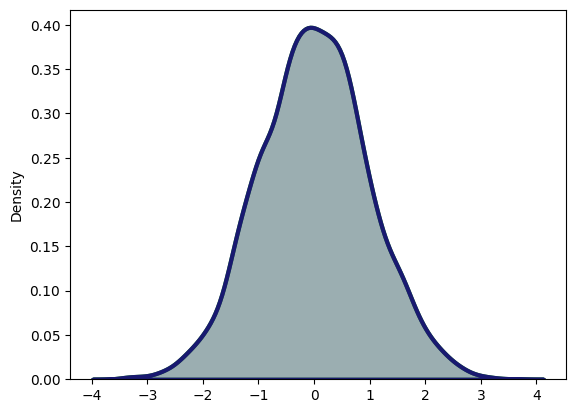

In [15]:


run_gene_comparison(0,0, filename='')



0.2148

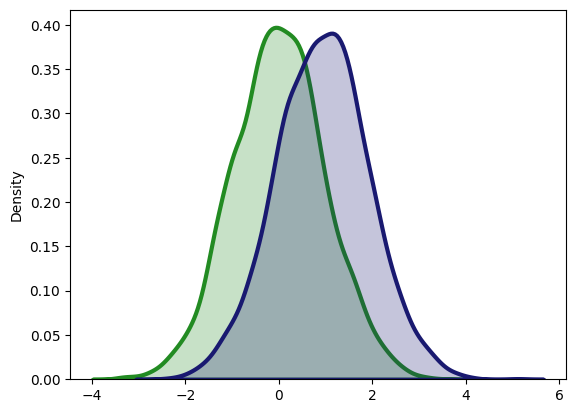

In [16]:
run_gene_comparison(0,5, filename='ZZZ_eg1')

1.9572

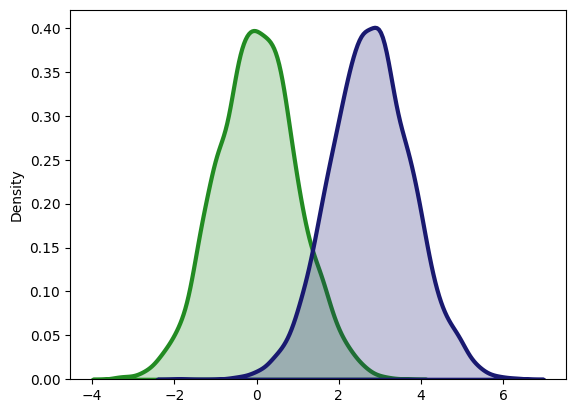

In [17]:
run_gene_comparison(0,15, filename='')

17.1586

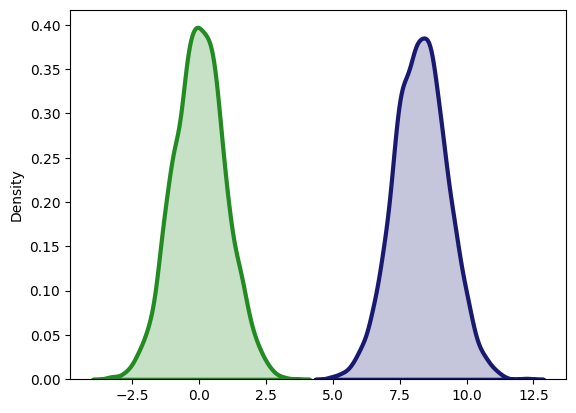

In [18]:
run_gene_comparison(0,45, filename='')


100%|██████████| 50/50 [00:00<00:00, 195.21it/s]


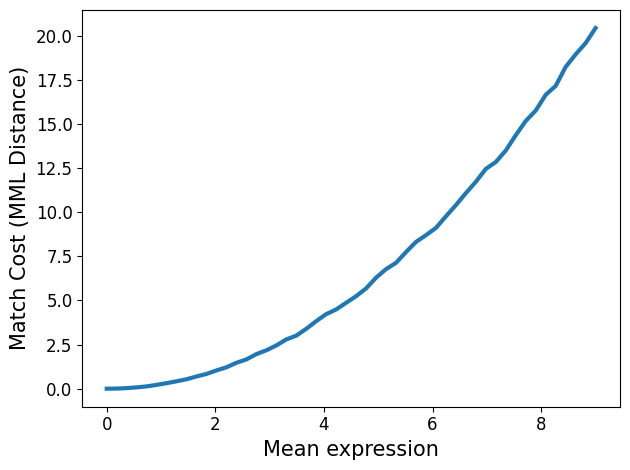

In [20]:
dists = []
for i in tqdm(range(0,len(datasets))):
    dists.append(compute_mmldist(datasets[0], datasets[i])) 

sb.lineplot(x=mean_range, y=dists, linewidth=3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Match Cost (MML Distance)', fontsize=15)
plt.xlabel('Mean expression',fontsize=15)
plt.tight_layout()
#plt.savefig('MML_distance_function.png')

In [35]:


torch.manual_seed(1)
var_datasets = [] 
std_range = np.linspace(0.1,3.0,50)
for std in std_range:
    var_datasets.append(MyFunctions.generate_random_dataset(5000,0.0,std)[0])

In [36]:
datasets = var_datasets

In [37]:
len(datasets)

50

-0.0012

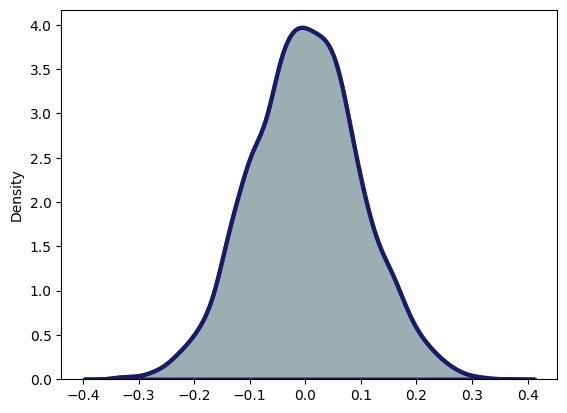

In [23]:


run_gene_comparison(0,0)



0.1172

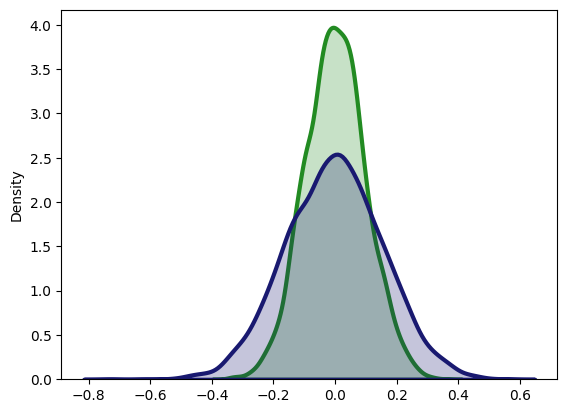

In [31]:
run_gene_comparison(0,1, filename='')

1.7367

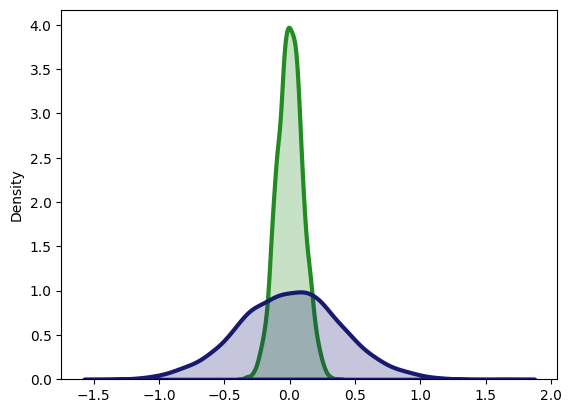

In [25]:


run_gene_comparison(0,5, filename='')



32.5647

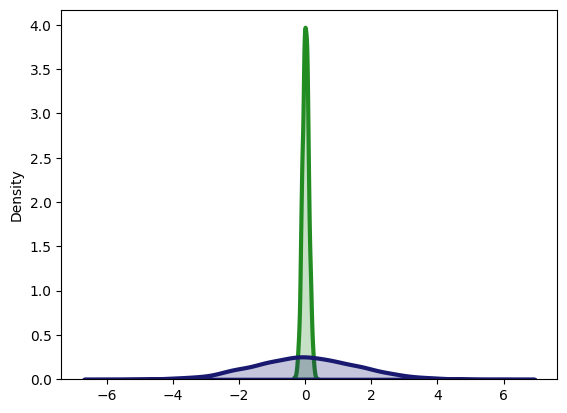

In [26]:


run_gene_comparison(0,25, filename='')



In [34]:
len(dists)
len(std_range)

50

100%|██████████| 50/50 [00:00<00:00, 191.09it/s]


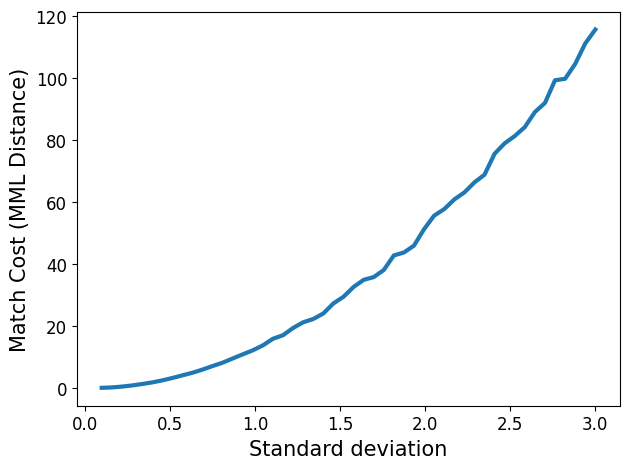

In [38]:
dists = []
for i in tqdm(range(0,len(datasets))):
    dists.append(compute_mmldist(datasets[0], datasets[i])) 
sb.lineplot(x=std_range, y=dists, linewidth=3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Match Cost (MML Distance)', fontsize=15)
plt.xlabel('Standard deviation',fontsize=15)
plt.tight_layout()
#savefig('MML_distance_function_const_mean0_var_std.png')

In [40]:


torch.manual_seed(1)
comb_datasets = {} 
mean_range = np.linspace(0,9.0,50)
std_range = np.linspace(0.1,3.0,50)
for std in std_range:
    for mean in mean_range:
        comb_datasets[(mean,std)] = MyFunctions.generate_random_dataset(5000,mean,std)[0]



In [ ]:
comb_datasets[(mean_range[3],std_range[5])]
comb_datasets[(mean_range[4],std_range[10])]


# i,j are timepoints
def run_gene_comparison(i, j,filename=''):
    print(i)
    print(j)
    sb.kdeplot(comb_datasets[i], fill=True, color='forestgreen', linewidth=3.0) # datasets[i] represents gene expression distribution at timepoint i
    sb.kdeplot(comb_datasets[j], fill=True, color='midnightblue', linewidth=3.0) # datasets[j] represents gene expression distribution at timepoint j
  #  plt.legend(['Reference','Query'])
    if(len(filename)>0):
        plt.savefig('../'+filename+'.pdf')

    return compute_mmldist(comb_datasets[i], comb_datasets[j])

run_gene_comparison((mean_range[3],std_range[5]),(mean_range[4],std_range[10]), filename='')

#run_gene_comparison(0,0)
#single_gene_plot(datasets[0],'forestgreen')
#single_gene_plot(datasets[5],'midnightblue')

In [ ]:


run_gene_comparison((mean_range[13],std_range[15]),(mean_range[30],std_range[21]), filename='')

